# System Design and my solution for the problem

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np

from pyspark.sql import SQLContext
from pyspark.sql.functions import lit, col, udf
from pyspark.sql import types

spark = SparkSession.builder.appName('Funnel Analysis').config('spark.executor.cores','4').getOrCreate()

sqlCtx = SQLContext(spark)

## Dummy data preparation

Since no data was provided for this task, I used a Kaggle data set located [here](https://www.kaggle.com/aerodinamicc/ecommerce-website-funnel-analysis) and modified it according to my needs in order to map it to the given coding assignment.

Relevant notebooks are located in the data_prep directory. For some of the steps, I have sampled a subset from the previous step in order to simulate a drop-off on each of the step. You can look at the notebook at `data_prep/data_prep.ipynb`. `data_prep/sample_db_creator.ipynb` prepares a SQLite DB for OLTP.

## 1) Data Collection and Frontend and Backend componenets

For the scenario described in the problem, I have assumed that some sort of event tracking is implemented in the OLTP database as follows:
- Whenever a logged in user visits a certain page in the funnel, an event is populated with its user id, date, sex, channel, device and the page. This happens on each of the page that is part of the funnel
- For now, I have assumed it to be a single product (for e.g. insurance policy purchase) but this can be extended to multiple products as well
- Ideally, I would want each event to be tracked via some sort of a cart session so multiple sessions for a user can be tracked but this isn't the case for now

A very basic preview of the event object is given below:

In [3]:
users = pd.read_csv("data_prep/data/users.csv", index_col="user_id")
users.head()

,date,device,sex,channel
user_id,,,,
450007,2015-02-28,Desktop,Female,search
756838,2015-01-13,Desktop,Male,paid_ads
568983,2015-04-09,Desktop,Male,paid_ads
190794,2015-02-18,Desktop,Female,search
537909,2015-01-15,Desktop,Male,paid_ads


In [4]:
step1 = pd.read_csv("data_prep/data/step1.csv", index_col="user_id")
step1.head()

,page
user_id,
313593,step1
468315,step1
264005,step1
290784,step1
639104,step1


## 2) How and where would you store the data

I am envisioning this data pipeline as a distributed system that takes care of not overwhelming OLTP databases and hence the user-facing products. My idea of this pipeline and data storage is inline with the following:
- OLTP database such as MySQL that stores application data. This also stores funnel event data
- Spark jobs to batch load events from OLTP on a nightly basis and put them into parquet file format into what I call a Data Lake. All jobs are scheduled via Airflow. This is for the most part, raw unprocessed data stored in a file system analogous to Hadoop
- My implemented Spark jobs are not fully production ready. Ideally, I would add some partitioning and throttling on my Spark jobs to make sure they don't bring down the OLTP and are capable of extracting deltas rather than doing a full load of the table every time
- Data Lake enables us to offload load from OLTP and gives us a rather unbounded plane to extract, slice and dice data, rinse and repeat, etc.
- Once we have the data in Data Lake, we can model it to however we want. This can be based on a teams need. In my case, I am applying some basic dimension modeling **(dimension_models package)** and expanding it to make my queries simpler and easier to follow
- Modeling is performed by Spark jobs (scheduled via Airflow) that load data from Data Lake and generate new dimension model tables. My understanding is that these dimension models can then be loaded into Snowflake or Redshift so that downstream teams can slice and dice data. Sample queries on dimension models are shown later in this notebook

### Airflow DAG dependencies

It's worth noticing that modeling jobs have to wait until the Data Lake extraction is complete. To make that possible, I have modeled DAGs in Airflow to take care of that using `ExternalTaskSensor` which waits for the previous DAG to complete before it starts the downstream DAG. I find this technique very useful for modeling data flows like this.

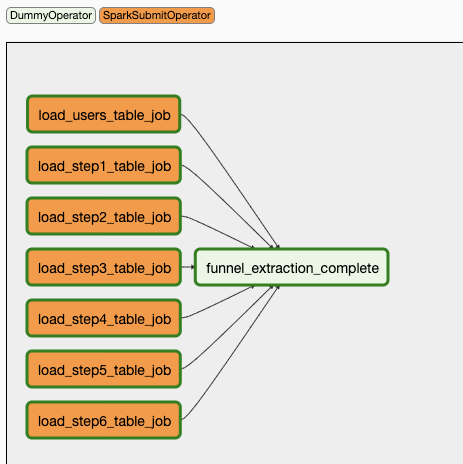
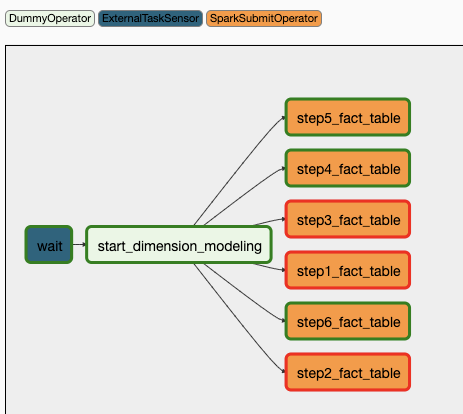
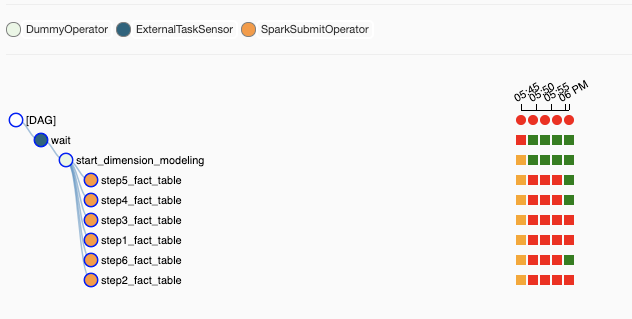

### System diagram

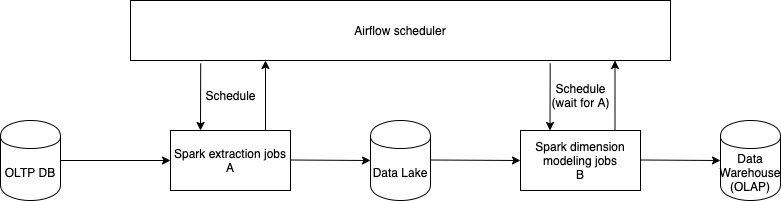

## 3) How will you generate Funnel Analysis

Following queries show some funnel analysis that I could think of using the dimension model tables stored in what I call the Datawarehouse. Headings are self-explanatory for what I am trying to do in the analysis.

### Adding and modifying columns before generating tables in warehouse

Before loading tables in the warehouse, I modified and generated a few columns based on the funnel analysis I was expecting to do. This is where I believe a raw Data Lake shines out in the sense that teams can create tables in warehouse according to their needs.

- Converted date strings to date type using Spark udf
```
string_to_date = udf(lambda x: datetime.strptime(x, '%Y-%m-%d'), types.DateType())
```
- Added an extra column to mark a visit. Note that we can even add an aggregation to this fact table if we want to such that we get optimized queries when performing joins
```
step1_fact = step1_fact.withColumn("visited", lit(1))
```

#### Load tables in Spark

In [2]:
users = spark.read.parquet("spark_jobs/datalake/users-2020-10-16/")
step4_fact = spark.read.parquet("spark_jobs/warehouse/step4_fact_table-2020-10-16/")
step5_fact = spark.read.parquet("spark_jobs/warehouse/step5_fact_table-2020-10-16/")
step6_fact = spark.read.parquet("spark_jobs/warehouse/step6_fact_table-2020-10-16/")

users.createOrReplaceTempView("users")
step4_fact.createOrReplaceTempView("step4_fact")
step5_fact.createOrReplaceTempView("step5_fact")
step6_fact.createOrReplaceTempView("step6_fact")

In [3]:
users.show(5)

+-------+----------+-------+------+--------+
|user_id|      date| device|   sex| channel|
+-------+----------+-------+------+--------+
| 450007|2015-02-28|Desktop|Female|  search|
| 756838|2015-01-13|Desktop|  Male|paid_ads|
| 568983|2015-04-09|Desktop|  Male|paid_ads|
| 190794|2015-02-18|Desktop|Female|  search|
| 537909|2015-01-15|Desktop|  Male|paid_ads|
+-------+----------+-------+------+--------+
only showing top 5 rows



In [4]:
step5_fact.show(5)

+-------+-------+
|user_id|visited|
+-------+-------+
| 838832|      1|
| 231324|      1|
|  13830|      1|
| 838723|      1|
| 205344|      1|
+-------+-------+
only showing top 5 rows



In [5]:
step6_fact.show(5)

+-------+-------+
|user_id|visited|
+-------+-------+
|  13830|      1|
| 559850|      1|
| 638114|      1|
| 581956|      1|
| 337704|      1|
+-------+-------+
only showing top 5 rows



#### Page visit trend for step 6 by sex, channel and month

In [7]:
spark.sql(
    """
    SELECT SUM(visited) AS total_visits, sex, channel, MONTH(users.date) AS month
    FROM step6_fact
    INNER JOIN users
    ON step6_fact.user_id = users.user_id
    GROUP BY month, sex, channel
    ORDER BY month
    """
).show()

+------------+------+--------+-----+
|total_visits|   sex| channel|month|
+------------+------+--------+-----+
|          38|Female|  search|    1|
|          30|  Male|  search|    1|
|          50|  Male|paid_ads|    1|
|          71|Female|paid_ads|    1|
|          45|  Male|paid_ads|    2|
|          42|  Male|  search|    2|
|          34|Female|  search|    2|
|          52|Female|paid_ads|    2|
|          11|Female|paid_ads|    3|
|          15|Female|  search|    3|
|          12|  Male|paid_ads|    3|
|           6|  Male|  search|    3|
|          13|  Male|paid_ads|    4|
|          17|Female|paid_ads|    4|
|           3|Female|  search|    4|
|          13|  Male|  search|    4|
+------------+------+--------+-----+



#### Percentage drop-off from step 5 to step 6 by sex and channel

In [8]:
spark.sql(
    """
    SELECT SUM(step5_fact.visited) AS total_step5_visits, SUM(step6_fact.visited) AS total_step6_visits,
    users.sex, users.channel,
    (100 - (SUM(step6_fact.visited) / SUM(step5_fact.visited)) * 100) AS perc_dropoff
    FROM step5_fact
    LEFT JOIN step6_fact
    ON step5_fact.user_id = step6_fact.user_id
    INNER JOIN users
    ON step5_fact.user_id = users.user_id
    GROUP BY users.sex, users.channel
    """
).show()

+------------------+------------------+------+--------+-----------------+
|total_step5_visits|total_step6_visits|   sex| channel|     perc_dropoff|
+------------------+------------------+------+--------+-----------------+
|              1170|                91|  Male|  search|92.22222222222223|
|              1251|                90|Female|  search|92.80575539568345|
|              1849|               151|Female|paid_ads| 91.8334234721471|
|              1760|               120|  Male|paid_ads|93.18181818181819|
+------------------+------------------+------+--------+-----------------+



#### Percentage drop-off from step 4 to step 5 by sex, channel and month

In [9]:
spark.sql(
    """
    SELECT SUM(step4_fact.visited) AS total_step4_visits, SUM(step5_fact.visited) AS total_step5_visits,
    users.sex, users.channel, MONTH(users.date) AS month,
    (100 - (SUM(step5_fact.visited) / SUM(step4_fact.visited)) * 100) AS perc_dropoff
    FROM step4_fact
    LEFT JOIN step5_fact
    ON step4_fact.user_id = step5_fact.user_id
    INNER JOIN users
    ON step4_fact.user_id = users.user_id
    GROUP BY users.sex, users.channel, month
    ORDER BY month ASC
    """
).show()

+------------------+------------------+------+--------+-----+-----------------+
|total_step4_visits|total_step5_visits|   sex| channel|month|     perc_dropoff|
+------------------+------------------+------+--------+-----+-----------------+
|              4169|               736|Female|paid_ads|    1|82.34588630366994|
|              4013|               697|  Male|paid_ads|    1|82.63144779466734|
|              2744|               507|Female|  search|    1|81.52332361516035|
|              2628|               450|  Male|  search|    1|82.87671232876713|
|              2771|               494|  Male|  search|    2|82.17250090220136|
|              4132|               745|Female|paid_ads|    2|81.96999031945789|
|              2688|               490|Female|  search|    2|81.77083333333334|
|              4096|               683|  Male|paid_ads|    2|    83.3251953125|
|              1726|               138|Female|  search|    3|92.00463499420626|
|              1695|               113| 

## 4) Assumptions made for the data pipeline

- Input data is for a single load and the reason why I haven't shown any partitioning on the SELECT queries
- Input data is stored in SQLite. This is never going to be the case in production. This is just a prototype
- Dimension tables would ideally be stored using conventional data warehousing tools such as Snowflake or Redshift

## 5) Tech used

- Airflow for job scheduling (helm chart included for k8s deployment)
- ExternalTaskSensor in Airflow
- DAG modeling in Airflow
- SparkSubmitOperator in Airflow
- Spark for loading tables into dummy Data Lake and Datawarehouse
- SQLite to mimic OLTP
- Jupyter notebooks for testing and brainstorming

## 6) Directories worth reviewing

- dags
- spark_jobs
- deployments
- data_prep